In [45]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
from multiprocessing import Process, Manager
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [46]:
contraceptive_data = pd.read_csv("contraceptive/contraceptive_for_students.csv")
contraceptive_data.head()

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [47]:
# Data Cleaning & Necessary Functions
valid_entries = {'wife_education':[1, 2, 3, 4],'husband_education':[1, 2, 3, 4], 'wife_religion':[0,1], 'wife_work':[0,1], 'husband_occupation':[1, 2, 3, 4], 'standard_living':[1, 2, 3, 4], 'media_exposure':[0,1], 'contraceptive':[1,2,3]}

dummy_data = pd.DataFrame.from_dict({'wife_age':[0, 0, 0, 0], 'num_child':[0, 0, 0, 0], 'wife_education':[1, 2, 3, 4],'husband_education':[1, 2, 3, 4], 'wife_religion':[0,1, 0, 1], 'wife_work':[0, 1, 0, 1], 'husband_occupation':[1, 2, 3, 4], 'standard_living':[1, 2, 3, 4], 'media_exposure':[0 , 1, 0, 1], 'contraceptive':[1, 2, 3, 1]}) # For DictVectorizer

def clean_data(dataset, rename_cols=None):
    dataset = dataset.copy()
    # Remove rows violating constraints
    dataset = dataset.fillna(-1)
    dataset = dataset.astype(int)
    dataset = dataset[(dataset['wife_age']>=0)&(dataset['num_child']>=0)&(dataset['wife_education'].isin(valid_entries['wife_education']))&(dataset['husband_education'].isin(valid_entries['husband_education']))&(dataset['wife_religion'].isin(valid_entries['wife_religion']))&(dataset['wife_work'].isin(valid_entries['wife_work']))&(dataset['husband_occupation'].isin(valid_entries['husband_occupation']))&(dataset['standard_living'].isin(valid_entries['standard_living']))&(dataset['media_exposure'].isin(valid_entries['media_exposure']))&(dataset['contraceptive'].isin(valid_entries['contraceptive']))]
    if rename_cols is not None:
        dataset = dataset.rename(columns=rename_cols)
    return dataset

def split_x_y(dataset, response):
    y = np.array(dataset[response])
    x = dataset.drop(response, axis=1)
    return (x, y)

def one_hot_encode_column(dataset, column_name):
    """
    One-hot-encoder
    """
    dataset = dataset.copy()
    vec_enc = DictVectorizer()
    vec_enc.fit(dataset[[column_name]].to_dict(orient='records'))
    ohe_data = vec_enc.transform(dataset[[column_name]].to_dict(orient='records')).toarray()
    ohe_cats = vec_enc.get_feature_names()
    ohe = pd.DataFrame(ohe_data, columns=ohe_cats)
    dataset = pd.concat([dataset, ohe], axis=1)
    dataset = dataset.drop(column_name, axis=1)
    return dataset

def one_hot_encode(dataset, columns, dummy=None):
    # One-hot encode categorical variables
    dataset = dataset.copy()
    if dummy is not None:
        dataset = dataset.append(dummy, ignore_index=True)
    dataset[columns] = dataset[columns].astype(str)
    for column in columns:
        dataset = one_hot_encode_column(dataset, column)
    if dummy is not None:
        dataset = dataset[:-len(dummy)]
    return dataset

def standardize(dataset, columns):
    # Standardize numerical columns
    dataset = dataset.copy()
    for column in columns:
        if dataset[column].std() > 0:
            dataset[column]=(dataset[column]-dataset[column].mean())/dataset[column].std()
    return dataset

def process_data(dataset, categorical_columns, numerical_columns, response, dummy=None):
    dataset = dataset.copy()
    dataset = clean_data(dataset)
    all_columns = categorical_columns + numerical_columns + [response]
    dataset = dataset[all_columns]
    if dummy is not None:
        dummy = dummy.copy()
        cols = categorical_columns + numerical_columns
        dummy = dummy[cols]
    x, y = split_x_y(dataset, response)
    if numerical_columns:
        x = standardize(x, numerical_columns)
    if categorical_columns:
        x = one_hot_encode(x, categorical_columns, dummy)
    return (x, y)

In [48]:
# Data Splitting
cleaned_data = clean_data(contraceptive_data) # Clean data, do not OHE or Standardize until modeling -> EDA first
train, test = train_test_split(cleaned_data, test_size=0.1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [49]:
# Exploratory Data Analysis
numerical = ['wife_age', 'num_child']
categorical = ['wife_education', 'husband_education', 'wife_religion', 'wife_work', 'husband_occupation', 'standard_living', 'media_exposure', 'contraceptive']
ordinal = ['wife_education', 'husband_education', 'standard_living', 'contraceptive']
nominal = ['wife_religion', 'wife_work', 'husband_occupation', 'media_exposure']
all_vars = numerical + categorical

In [50]:
# Making a cleaned version of the data for readability and EDA
renamed_columns = {"wife_education": "Wife Education", "husband_education": "Husband Education", "contraceptive": "Contraceptive", 'wife_age': "Wife Age", "num_child": "Number of Children", 'wife_religion': 'Wife Religion', 'wife_work': 'Wife Work', 'husband_occupation': "Husband Occupation", "standard_living": "Standard of Living", "media_exposure": "Media Exposure"}
eda_data = contraceptive_data.copy()
eda_data = clean_data(eda_data, renamed_columns)
eda_data.head()

,Wife Age,Wife Education,Husband Education,Number of Children,Wife Religion,Wife Work,Husband Occupation,Standard of Living,Media Exposure,Contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


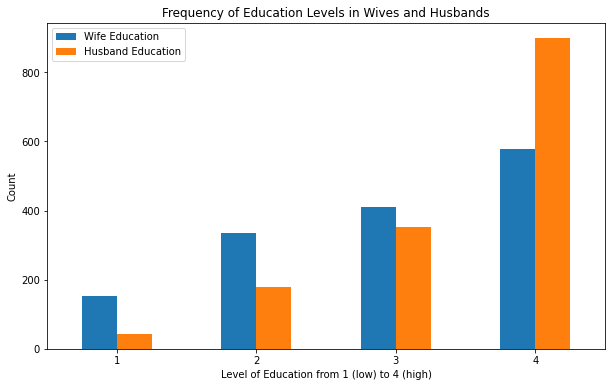

In [51]:
# Wife and Husband Level of Education Counts 
education_counts = pd.DataFrame()
education_counts["Wife Education"] = eda_data["Wife Education"].value_counts(ascending=True)
education_counts["Husband Education"] = eda_data["Husband Education"].value_counts(ascending=True)

education_counts.plot.bar(rot=0, figsize=(10,6))

plt.xlabel('Level of Education from 1 (low) to 4 (high)')
plt.ylabel('Count')
plt.title("Frequency of Education Levels in Wives and Husbands");

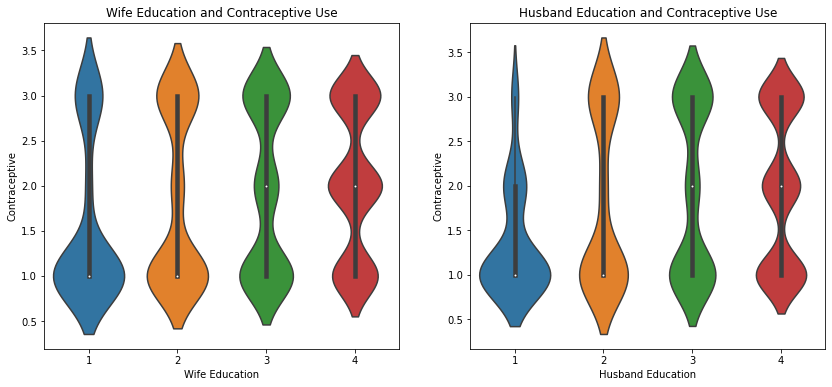

In [52]:
# Wife & Husband Combined Education and Contraceptive Use
combined_edu = eda_data[["Wife Education", "Husband Education", "Contraceptive"]]

f, ax = plt.subplots(1, 2, figsize=(14,6))
sns.violinplot(data=combined_edu, x='Wife Education', y='Contraceptive', ax=ax[0])
sns.violinplot(data=combined_edu, x='Husband Education', y='Contraceptive', ax=ax[1]);

ax[0].set_title("Wife Education and Contraceptive Use")
ax[1].set_title("Husband Education and Contraceptive Use");

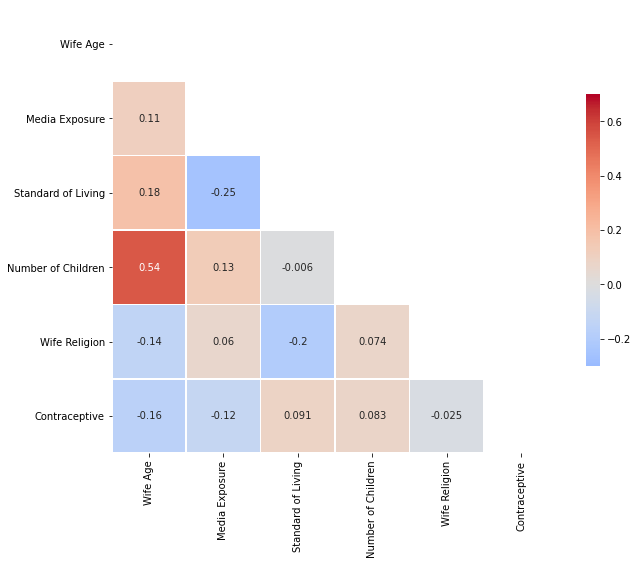

In [53]:
#Heatmap displaying correlation between different features

heatmap_df = eda_data[['Wife Age', 'Media Exposure', 'Standard of Living', 'Number of Children', 'Wife Religion', 'Contraceptive']]
corr = heatmap_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, vmax=0.7, mask=mask, vmin=-0.3, center=0, cmap='coolwarm',
square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

**Conclusion:** Number of Children and Wife Age have a very high correlation and could be interpreted as redundancy, so we are choosing not to ignore it.

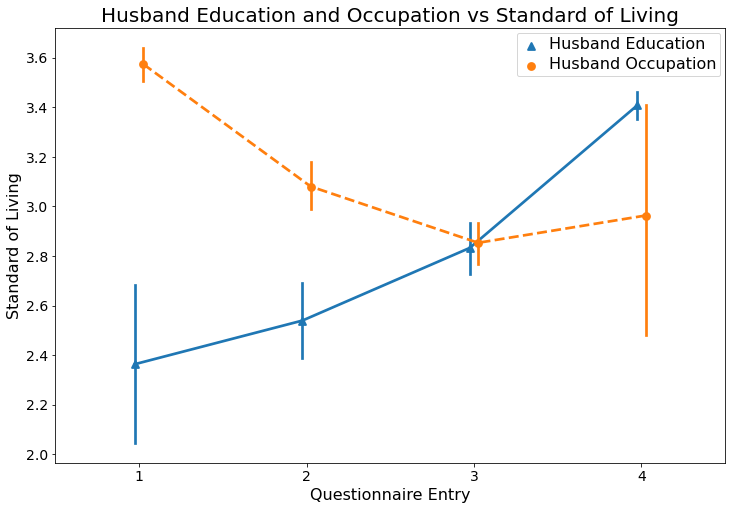

In [54]:
edu_occu_stand = eda_data[['Husband Education', 'Standard of Living']].rename(columns={'Husband Education': 'Questionnaire Entry'})
edu_occu_stand['Metric'] = ['Husband Education' for i in range(1473)]

occu_table = eda_data[['Husband Occupation', 'Standard of Living']].rename(columns={'Husband Occupation': 'Questionnaire Entry'})
occu_table['Metric'] = ['Husband Occupation' for i in range(1473)]

edu_occu_stand = edu_occu_stand.append(occu_table)

fig, ax = plt.subplots(figsize=(12, 8))
sns.pointplot(x="Questionnaire Entry", y="Standard of Living", hue="Metric", markers=["^", "o"], linestyles=["-", "--"], data=edu_occu_stand, ci=95, dodge=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:])
plt.setp(ax.get_legend().get_texts(), fontsize='16')
plt.title("Husband Education and Occupation vs Standard of Living",fontsize=20)
plt.xlabel("Questionnaire Entry",fontsize=16)
plt.ylabel("Standard of Living",fontsize=16)
plt.tick_params(labelsize=14)

**Conclusion:** Standard of Living and Husband Education appear positively correlated and Standard of Living and Husband Occupation appear negatively correlated.

In [3]:
# Model Generation - classification task -> Logistic Regression, Decision Trees, Random Forest, KNN, SVM
def model_generation(dataset, categorical_columns, numerical_columns, response, model_name, store, dummy=None):
    print("Processing model: " + model_name)
    x, y = process_data(dataset, categorical_columns, numerical_columns, response, dummy)
    logistic_model_cv = LogisticRegressionCV(multi_class='multinomial')
    param_grid_tree = {'max_depth':np.arange(5, 22)}
    decisionTree_model = DecisionTreeClassifier()
    decisionTree_model_gscv = GridSearchCV(decisionTree_model, param_grid_tree, cv=5)
    randomForest_model = RandomForestClassifier()
    randomForest_model_gscv = GridSearchCV(randomForest_model, param_grid_tree, cv=5)
    knn_model = KNeighborsClassifier()
    param_grid_knn = {'n_neighbors':np.arange(1, 21)}
    knn_model_gscv = GridSearchCV(knn_model, param_grid_knn, cv=5)
    svm_model = SVC()
    param_grid_svm = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
    svm_model_gscv = GridSearchCV(svm_model, param_grid_svm, cv=5)
    models = [logistic_model_cv, decisionTree_model_gscv, randomForest_model_gscv, knn_model_gscv, svm_model_gscv]
    train_scores = [cross_val_score(model, x, y, scoring='accuracy', cv=10).mean() for model in models]
    print(model_name + " train scores:" + str(train_scores))
    chosen_model = models[np.argmax(train_scores)]
    chosen_model.fit(x, y)
    print(model_name + " Final Train Acc:" + str(chosen_model.score(x, y)))
    store[model_name] = chosen_model

In [56]:
# Models - predict contraceptive all columns, predict contraceptive no wife age, predict contraceptive no number of children, predict standard of living from husband occupation and education, predict standard living all columns
print("Models: Logistic Regression, Decision Tree, Random Forest, K Nearest Neighbors, Support Vector Machine")
manager = Manager()
models = manager.dict()
categorical_no_contraceptive = categorical[:]
categorical_no_contraceptive.remove('contraceptive')
contraceptive_all_data_process = Process(target=model_generation, args=(train, categorical_no_contraceptive, numerical, 'contraceptive', "Contraceptive All Data", models, dummy_data))
contraceptive_all_data_process.start()
numerical_no_wife_age = numerical[:]
numerical_no_wife_age.remove('wife_age')
contraceptive_no_wife_age_process = Process(target=model_generation, args=(train, categorical_no_contraceptive, numerical_no_wife_age, 'contraceptive', "Contraceptive No Wife Age", models, dummy_data))
contraceptive_no_wife_age_process.start()
numerical_no_num_child = numerical[:]
numerical_no_num_child.remove('num_child')
contraceptive_no_num_child_process = Process(target=model_generation, args=(train, categorical_no_contraceptive, numerical_no_num_child, 'contraceptive', "Contraceptive No Num Child", models, dummy_data))
contraceptive_no_num_child_process.start()
standard_living_husband_process = Process(target=model_generation, args=(train, ['husband_occupation', 'husband_education'], [], 'standard_living', "Standard Living Only Husband Occupation/Education", models, dummy_data))
standard_living_husband_process.start()
categorical_no_standard_living = categorical[:]
categorical_no_standard_living.remove('standard_living')
standard_living_all_data_process = Process(target=model_generation, args=(train, categorical_no_standard_living, numerical, 'standard_living',  "Standard Living All Data", models, dummy_data))
standard_living_all_data_process.start()

contraceptive_all_data_process.join()
contraceptive_no_wife_age_process.join()
contraceptive_no_num_child_process.join()
standard_living_husband_process.join()
standard_living_all_data_process.join()
contraceptive_all_data_model = models["Contraceptive All Data"]
contraceptive_no_wife_age_model = models["Contraceptive No Wife Age"]
contraceptive_no_num_child_model = models["Contraceptive No Num Child"]
standard_living_husband_model = models["Standard Living Only Husband Occupation/Education"]
standard_living_all_data_model = models["Standard Living All Data"]

Models: Logistic Regression, Decision Tree, Random Forest, K Nearest Neighbors, Support Vector Machine
Processing model: Contraceptive All Data
Processing model: Contraceptive No Wife Age
Processing model: Contraceptive No Num Child
Processing model: Standard Living Only Husband Occupation/Education
Processing model: Standard Living All Data
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfg

In [57]:
# Model Testing
# Construct (x, y) pairs
x_test_contraceptive_all_data, y_test_contraceptive_all_data = process_data(test, categorical_no_contraceptive, numerical, 'contraceptive', dummy_data)
x_test_contraceptive_no_wife_age, y_test_contraceptive_no_wife_age = process_data(test, categorical_no_contraceptive, numerical_no_wife_age, 'contraceptive', dummy_data)
x_test_contraceptive_no_num_child, y_test_contraceptive_no_num_child = process_data(test, categorical_no_contraceptive, numerical_no_num_child, 'contraceptive', dummy_data)
x_test_standard_living_husband, y_test_standard_living_husband = process_data(test, ['husband_occupation', 'husband_education'], [], 'standard_living', dummy_data)
x_test_standard_living_all_data, y_test_standard_living_all_data = process_data(test, categorical_no_standard_living, numerical, 'standard_living', dummy_data)
# Make Predictions
prediction_contraceptive_all_data = contraceptive_all_data_model.predict(x_test_contraceptive_all_data)
prediction_contraceptive_no_wife_age = contraceptive_no_wife_age_model.predict(x_test_contraceptive_no_wife_age)
prediction_contraceptive_no_num_child = contraceptive_no_num_child_model.predict(x_test_contraceptive_no_num_child)
prediction_standard_living_husband = standard_living_husband_model.predict(x_test_standard_living_husband)
prediction_standard_living_all_data = standard_living_all_data_model.predict(x_test_standard_living_all_data)
# Accuracy
print("Contraceptive All Data")
print(accuracy_score(prediction_contraceptive_all_data, y_test_contraceptive_all_data))
print("Contraceptive No Wife Age")
print(accuracy_score(prediction_contraceptive_no_wife_age, y_test_contraceptive_no_wife_age))
print("Contraceptive No Num Child")
print(accuracy_score(prediction_contraceptive_no_num_child, y_test_contraceptive_no_num_child))
print("Standard Living Only Husband Occupation, Education")
print(accuracy_score(prediction_standard_living_husband, y_test_standard_living_husband))
print("Standard Living All Data")
print(accuracy_score(prediction_standard_living_all_data, y_test_standard_living_all_data))

Contraceptive All Data
0.5878378378378378
Contraceptive No Wife Age
0.5405405405405406
Contraceptive No Num Child
0.44594594594594594
Standard Living Only Husband Occupation, Education
0.4594594594594595
Standard Living All Data
0.49324324324324326


Interpret Results:
From the accuracy numbers above, it can be seen that wife age and number of children are not completely correlated with each other, as the accuracy falls about 4% when not considering wife age (so much of the contraceptive use explained by wife age can be explained by number of children instead), but far more when not considering number of children (so wife age cannot fully explain number of children). Also, it seems that much of the standard of living can be explained by just husband occupation and education, as the accuracy falls by only 3-4% when only considering those factors.